# Demo for looking at eye and head movements in real world coordinates


## Import relevant packages

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Import packages
import os
import pandas as pd
import numpy as np
import cv2
import json
#import ffmpegcv 
from scipy import signal
from sys import platform
from itertools import compress 
from itertools import count
import glob


# Plotting thigs
import matplotlib.pyplot as plt
import matplotlib.patches as pltrec
from matplotlib.widgets import Slider, Button, CheckButtons
import ipympl

# Import the analysis functions 
import AnalysisTools as at

# Get system name 
SystemName  = platform

##########################################################################
## setting paths 
abspath = os.path.abspath('WorldCoordinatesDemo.ipynb') # Get the Path of this script
dname = os.path.dirname(abspath) # Get the directory
os.chdir(dname) # Set this to your current working directoy

## Now load the data

Data Structure should be as follows. Per Recording, there should be one folder that has the following files: 
1. gaze.csv 
2. imu.csv
3. world_timestamps.csv
4. world.mp4 (This file is typically named differently, for ease of use it should be renamed to world)



In [2]:
# Define the datapath to the data
Datapath = '../Data_World/' # Data should be a folder on the same level as the Code Folder

### Set the Name of the recording you want to analyze 
Rec = 'Eye+Head'

######################################################
# Get the behavioural data 
print(os.path.join(Datapath,Rec,'gaze.csv'))
Eye = pd.read_csv(os.path.join(Datapath,Rec,'gaze.csv')) # Get the gaze position
Eye3D = pd.read_csv(os.path.join(Datapath,Rec,'3d_eye_states.csv')) # Get the gaze position

Head = pd.read_csv(os.path.join(Datapath,Rec,'imu.csv')) # Get the Head position via the imu data
Video = pd.read_csv(os.path.join(Datapath,Rec,'world_timestamps.csv')) # Get the timestamps of the video 

Events = pd.read_csv(os.path.join(Datapath,Rec,'events.csv'))

# Find the video 
vidname = glob.glob(os.path.join(Datapath,Rec,'*.mp4'))
cap = cv2.VideoCapture(vidname[0]) # World Video

########################################################################################
## Add toggles to decide what to analyze 
AnalyzeSacc = 1 # if 1 you will label saccades 
AnalyzeSmooth = 1 # if 1 you will label smooth eye movements
AnalyzeHead = 1 # if 1 you will analyze head movements
AnalyzeBlinks =1 # if 1 you will save the blinks
IntFigureLabel = 1 # if 1 you will show the labeling figure 
AnalyzeSceneLabelling = 0 # if 1 you want to analyze the scene camera
DepthLabelling = 1 # if 1 you want to analyze the scene camera

Visualize = 0 # if 1 you will try to visualize the results 


../Data_World/Eye+Head/gaze.csv


#### Run some tests to check the data recordings 

In [3]:
at.test_dataformats(Eye,Head,Video,cap) # test whether the shape of the data is correct

## Read out the variables you need for the analysis and compute velocities

Things you want to have: 
1. Gaze position in pixels and degrees and their sampling 
2. The head position in deg 

Then compute the eye and head velocity (this is already available for the head movements).
For computing the eye velocity, you want to add a filter to the gaze data to reduce noise.
Also get the sampling of the different components and align them on the same time scale.



In [4]:
""" This is for the isolated eye movements """

## Get the relevant Data 
xpos = Eye['gaze x [px]'].to_numpy() # Eye position in pixel x 
ypos = Eye['gaze y [px]'].to_numpy() # Eye position in pixel y 
xdeg = Eye['azimuth [deg]'].to_numpy() # Eye position in pixel x 
ydeg = Eye['elevation [deg]'].to_numpy() # Eye position in pixel y 
time_eye= Eye['timestamp [ns]'].to_numpy()/10**6 # Timestamps of the eye recording divided by 10^6 to turn it into ms

## Setup the Filter 
b,a = signal.butter(2, 20, 'low', fs=200, output='ba')

## Filter the eye data
xpos = signal.filtfilt(b,a,xpos) # Xpos in Pixel
ypos = signal.filtfilt(b,a,ypos) # Ypos in Pixel
xdeg = signal.filtfilt(b,a,xdeg) # Xpos in Deg
ydeg = signal.filtfilt(b,a,ydeg) # Ypos in Deg

## Compute the velocity 
# Velocity in deg per second
vel_x = at.HesselsVelocity(xdeg,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_y = at.HesselsVelocity(ydeg,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_eye = np.hypot(vel_x,vel_y)
#vel_eye = signal.filtfilt(b,a,vel_eye) # Xpos in Pixel

# Velocity in Pixel per second
vel_x_pix = at.HesselsVelocity(xpos,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_y_pix = at.HesselsVelocity(ypos,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_eye_pix = np.hypot(vel_x_pix,vel_y_pix)



In [5]:
""" This is for the isolated head movements """

PitchDeg = Head['pitch [deg]'].to_numpy() # Read out the positions in deg
YawDeg = Head['yaw [deg]'].to_numpy()
RollDeg = Head['roll [deg]'].to_numpy()
time_head = Head['timestamp [ns]'].to_numpy()/10**6

vx_head = Head['gyro z [deg/s]'].to_numpy() *-1 # The velocities are already available from the gyroscope
vy_head = Head['gyro x [deg/s]'].to_numpy()
vz_head = Head['gyro y [deg/s]'].to_numpy()
v_head = np.hypot(vx_head,vy_head) # 2d velocity in x and y plane relative to camera




In [6]:
## Align the timings 

time_video = Video['timestamp [ns]'].to_numpy()/10**6 # Get the timing from the video file 

info = []
with open(Datapath+Rec + "/info.json", "r") as f:
    info = json.load(f)
NormTime =info["start_time"]/10**6# Define a common start point, the initial frame of the eye recording 

# Update the time variables
time_eye = time_eye-NormTime 
time_video = time_video-NormTime
time_head = time_head-NormTime
TrialOnsets = Events["timestamp [ns]"].to_numpy()/10**6-NormTime # Get the events set in the video in the same timeframe
TrialOnsets = TrialOnsets[1:-1] # Exclude recording on and offset


In [7]:
""" Now also represent eye and head together in world coordinates"""

# Resample the head signal to match the gaze signal
quaternions_resampled = np.array(
    [
        np.interp(time_eye, time_head, Head["quaternion x"]),
        np.interp(time_eye, time_head, Head["quaternion y"]),
        np.interp(time_eye, time_head, Head["quaternion z"]),
        np.interp(time_eye, time_head, Head["quaternion w"]),
    ]
).T


# Now, we can apply the functions --> see https://docs.pupil-labs.com/alpha-lab/imu-transformations/
headings_in_world = at.imu_heading_in_world(quaternions_resampled)

cart_gazes_in_world = at.gaze_3d_to_world(
    ydeg, xdeg, quaternions_resampled
)

[world_head_elevation, world_head_azimuth] = at.cartesian_to_spherical_world(headings_in_world)
[world_gaze_elevation, world_gaze_azimuth] = at.cartesian_to_spherical_world(cart_gazes_in_world)


In [8]:
## Filter the world coordinates in the same way: 

b,a = signal.butter(2, 20, 'low', fs=200, output='ba')
world_head_elevation = signal.filtfilt(b,a,world_head_elevation) # Head position in Deg
world_head_azimuth = signal.filtfilt(b,a,world_head_azimuth)

world_gaze_elevation = signal.filtfilt(b,a,world_gaze_elevation) # Gaze position in Deg
world_gaze_azimuth = signal.filtfilt(b,a,world_gaze_azimuth)


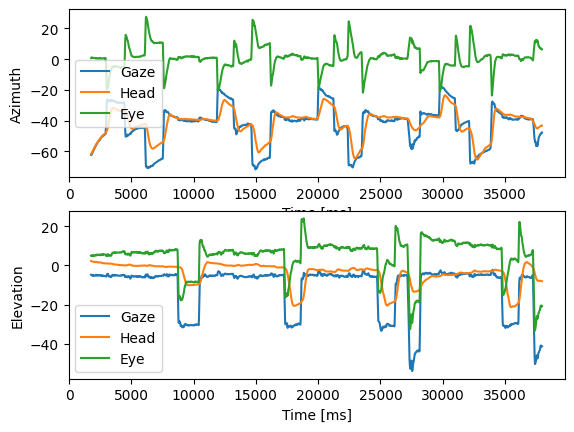

In [9]:
## Show a dummy plot of all of the data to visualize the data 
%matplotlib inline 
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(time_eye,world_gaze_azimuth,label = 'Gaze')
ax1.plot(time_eye,world_head_azimuth,label = 'Head')
ax1.plot(time_eye,xdeg,label = 'Eye')
ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Azimuth')
ax1.legend()

ax2.plot(time_eye,world_gaze_elevation,label = 'Gaze')
ax2.plot(time_eye,world_head_elevation,label = 'Head')
ax2.plot(time_eye,ydeg,label = 'Eye')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Elevation')
ax2.legend()


## Deinfe Characteristics of the "Experiment"

In [10]:

# Target positions 
ViewingDist = 120 # cm 
Target0 = [0, 0] # Center on this target 
Target1 = [np.arctan ((-50/ViewingDist))*(180/np.pi), 0]
Target2 = [np.arctan ((70/ViewingDist))*(180/np.pi), 0] # cm Relative to Target 0
Target3 = [0, np.arctan ((-60/ViewingDist))*(180/np.pi)] # cm Relative to Target 0


0 2520.612060546875
1 5190.861083984375
2 8351.06494140625
3 11190.906005859375
4 13741.01904296875
5 16670.56494140625
6 19148.477783203125
7 22056.640869140625
8 24319.203125
9 29364.576904296875
10 31457.47900390625
11 34394.98388671875


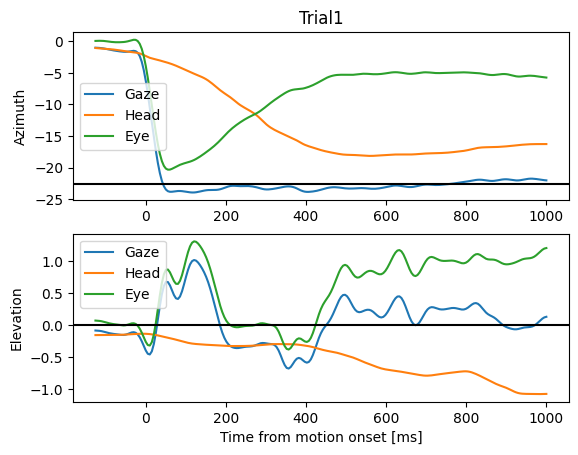

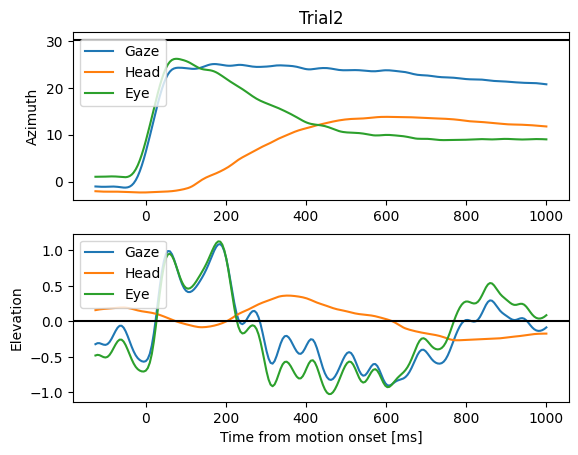

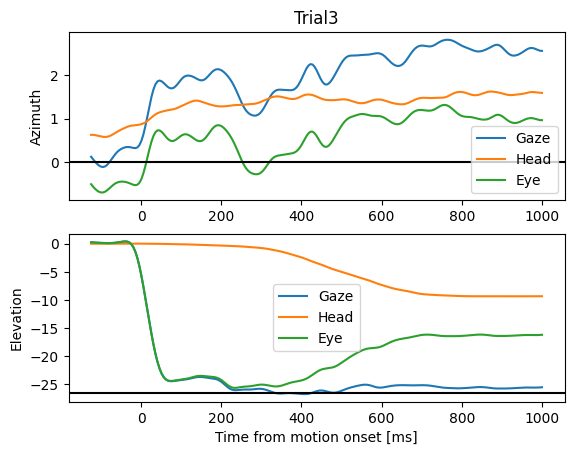

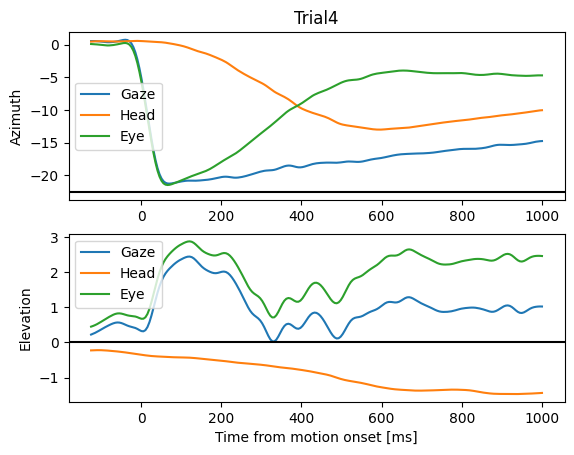

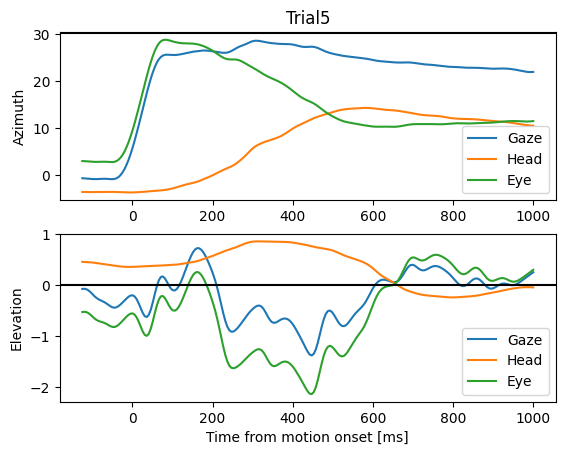

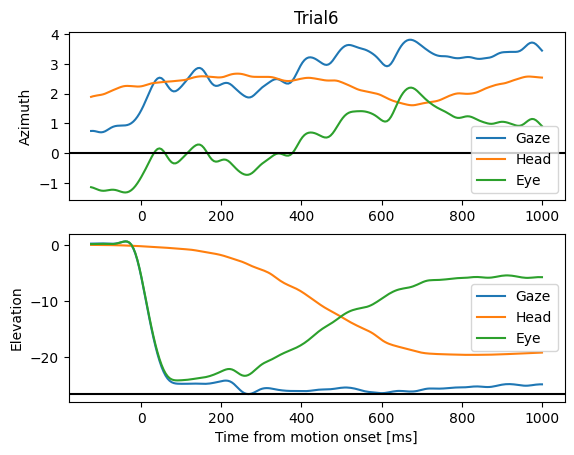

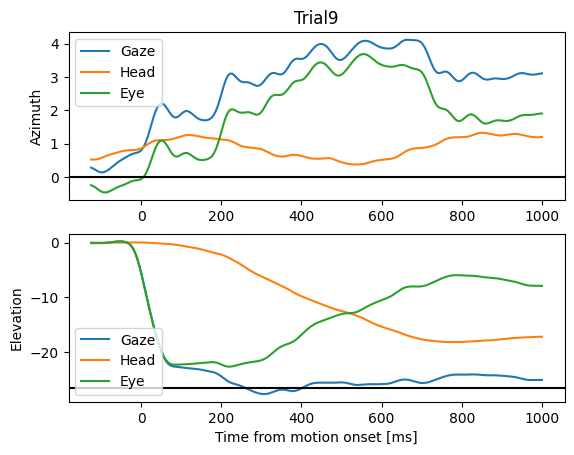

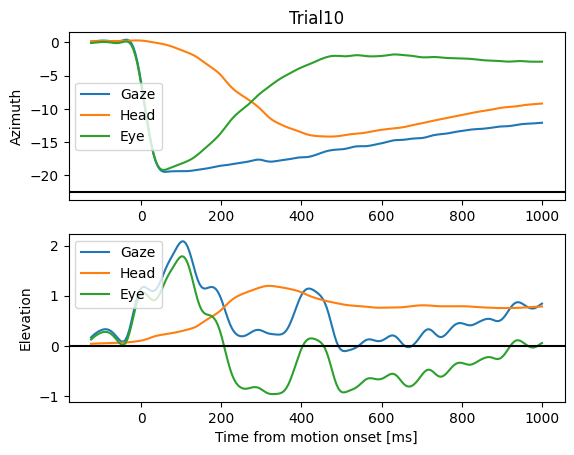

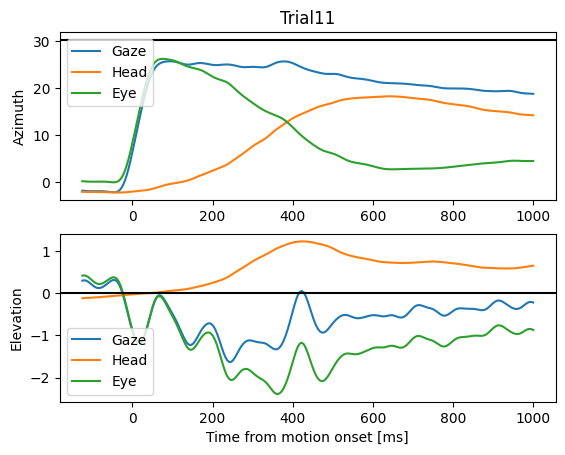

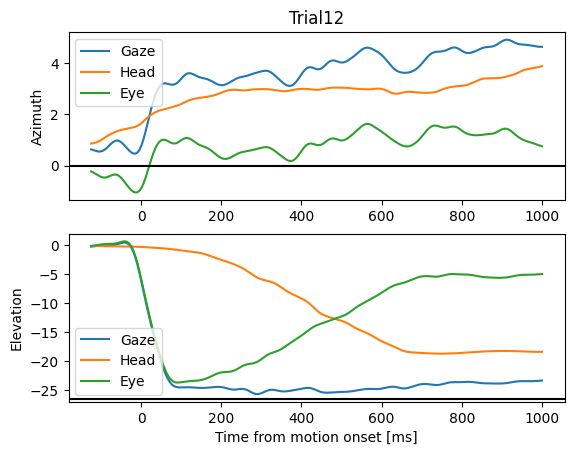

In [11]:
## Now loop through the trials to isolate the data 

# Init some variables 

x_gaze_all = np.zeros((len(TrialOnsets),225))
y_gaze_all = np.zeros((len(TrialOnsets),225))
x_head_all = np.zeros((len(TrialOnsets),225))
y_head_all = np.zeros((len(TrialOnsets),225))
x_eye_all = np.zeros((len(TrialOnsets),225))
y_eye_all = np.zeros((len(TrialOnsets),225))

Offset_x_all = np.zeros((len(TrialOnsets),3))
Offset_y_all = np.zeros((len(TrialOnsets),3))


for idx, trial in enumerate(TrialOnsets):

    print(idx,trial)
    On = trial
    Off = On+3000

    OnIdx = int(np.min(np.array((np.where(np.abs(time_eye-On)==np.min(np.abs(time_eye-On)))))))# Find the actual temporal sample that is the closest
    OffIdx = int(np.min(np.array((np.where(np.abs(time_eye-Off)==np.min(np.abs(time_eye-Off)))))))# Find the actual temporal sample that is the closest

    x_gaze = (world_gaze_azimuth [OnIdx:OffIdx] -np.median(world_gaze_azimuth[OnIdx:OnIdx+50]))*-1 # Invert it to match the same coordinate system
    y_gaze = world_gaze_elevation [OnIdx:OffIdx] - np.median(world_gaze_elevation[OnIdx:OnIdx+50])

    x_head = (world_head_azimuth [OnIdx:OffIdx]- np.median(world_head_azimuth[OnIdx:OnIdx+50]))*-1 # Invert it to match the same coordinate system
    y_head = world_head_elevation[OnIdx:OffIdx] - np.median(world_head_elevation[OnIdx:OnIdx+50])

    x_eye = x_gaze-x_head
    y_eye = y_gaze-y_head


    # Get a basic definition of movement onset 

    Dist = np.sqrt(x_gaze**2 + y_gaze**2) 
    Onset = int(np.min(np.array((np.where(Dist > 5)))))


    # Align the movements on it
    x_gaze_align = x_gaze[Onset-25:Onset+200]
    y_gaze_align = y_gaze[Onset-25:Onset+200]
    x_head_align = x_head[Onset-25:Onset+200]
    y_head_align = y_head[Onset-25:Onset+200]
    x_eye_align = x_eye[Onset-25:Onset+200]
    y_eye_align = y_eye[Onset-25:Onset+200]
    time_vek = np.linspace(-25*5,200*5,225)

    # Get a proxy for the target position 
    if np.median(x_gaze_align) > 0:
        TarPos = Target2
    else: 
        TarPos = Target1

    if np.median(y_gaze_align) < -5:
        TarPos = Target3 

    # Save them 
    x_gaze_all[idx,:] = x_gaze_align
    y_gaze_all[idx,:] = y_gaze_align
    x_head_all[idx,:] = x_head_align
    y_head_all[idx,:] = y_head_align
    x_eye_all[idx,:] = x_eye_align
    y_eye_all[idx,:] = y_eye_align

    # Compute the average angles of the different contributions 
    Offset_x_all[idx,:] = [np.median(x_gaze_align[50:100]), np.median(x_head_align[50:100]), np.median(x_eye_align[50:100])]
    Offset_y_all[idx,:] = [np.median(y_gaze_align[50:100]), np.median(y_head_align[50:100]), np.median(y_eye_align[50:100])]

    # perform a baseline correction
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.title.set_text('Trial' + str(idx +1))
    ax1.plot(time_vek,x_gaze_align,label = 'Gaze')
    ax1.plot(time_vek,x_head_align,label = 'Head')
    ax1.plot(time_vek,x_eye_align,label = 'Eye')
    ax1.axhline( y = TarPos[0], color = 'k')
    ax2.set_xlabel('Time from motion onset [ms]')
    ax1.set_ylabel('Azimuth')
    ax1.legend()

    ax2.plot(time_vek,y_gaze_align,label = 'Gaze')
    ax2.plot(time_vek,y_head_align,label = 'Head')
    ax2.plot(time_vek,y_eye_align,label = 'Eye')
    ax2.set_xlabel('Time from motion onset [ms]')
    ax2.axhline( y = TarPos[1], color = 'k')
    ax2.set_ylabel('Elevation')
    ax2.legend()





In [12]:
Condition1 = [0,3,6,9]
Condition2 = [1,4,7,10]
Condition3 = [2,5,8,11]

Mat_x_gaze = np.asarray((Offset_x_all[np.asarray(Condition1),0],Offset_x_all[np.asarray(Condition2),0],Offset_x_all[np.asarray(Condition3),0]))
Mat_x_gaze = np.transpose(Mat_x_gaze)
Mat_x_head = np.asarray((Offset_x_all[np.asarray(Condition1),1],Offset_x_all[np.asarray(Condition2),1],Offset_x_all[np.asarray(Condition3),1]))
Mat_x_head = np.transpose(Mat_x_head)
Mat_x_eye = np.asarray((Offset_x_all[np.asarray(Condition1),2],Offset_x_all[np.asarray(Condition2),2],Offset_x_all[np.asarray(Condition3),2]))
Mat_x_eye = np.transpose(Mat_x_eye)

Mat_y_gaze = np.asarray((Offset_y_all[np.asarray(Condition1),0],Offset_y_all[np.asarray(Condition2),0],Offset_y_all[np.asarray(Condition3),0]))
Mat_y_gaze = np.transpose(Mat_y_gaze)
Mat_y_head = np.asarray((Offset_y_all[np.asarray(Condition1),1],Offset_y_all[np.asarray(Condition2),1],Offset_y_all[np.asarray(Condition3),1]))
Mat_y_head = np.transpose(Mat_y_head)
Mat_y_eye = np.asarray((Offset_y_all[np.asarray(Condition1),2],Offset_y_all[np.asarray(Condition2),2],Offset_y_all[np.asarray(Condition3),2]))
Mat_y_eye = np.transpose(Mat_y_eye)


fig, (ax1, ax2) = plt.subplots(2,1)

ax1.violinplot(Mat_x_gaze,positions = [1,2,3])
ax1.violinplot(Mat_x_head,positions = [1.1,2.1,3.1])
ax1.violinplot(Mat_x_eye,positions = [0.9, 1.9, 2.9])

ax2.violinplot(Mat_y_gaze,positions = [1,2,3])
ax2.violinplot(Mat_y_head,positions = [1.1,2.1,3.1])
ax2.violinplot(Mat_y_eye,positions = [0.9, 1.9, 2.9])


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f6b4ab32a40>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f6b4ab329e0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f6b4ab33850>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f6b4ab33c70>}